# Plot Monitors on top of AOD using `cartopy`

In my [last notebook][notebook-link], I overlayed state capitol locations on top of an AOD plot using `cartopy`. Now, I will try to do the same with air quality monitors. This will involve retrieving monitoring data in R using the `PWFSLSmoke` package, importing the data into Python, and plotting in on top of the AOD plot using color to represent AQI values.

[notebook-link]: add_known_locations_to_cartopy_plots_2019-04-05.ipynb

## Goal

Plot air quality monitors colored by AQI value on top of AOD data 

## Generate monitoring data

To generate a CSV containing the latitudes, longitudes and pm2.5 values for all airsis, WRCC, and EPA air quality monitors, I used the following R script, which can also be found in `write_monitor_csv.R`.

```R
library(PWFSLSmoke)
library(lubridate)

datetime <- "201903191512"

aod_datetime <- as_datetime(datetime,
                            format="%Y%m%d%H%M")

# Retrieve data for 3 days preceding the time that the AOD data was collected
# to apply nowcast algorithm
monitor <- monitor_load(aod_datetime - days(3), aod_datetime)

# apply nowcast algorithm and retrieve the hour associated with AOD data
monitor_data <-
  monitor_nowcast(monitor) %>%
  monitor_extractData() %>%
  dplyr::filter(datetime == floor_date(aod_datetime, unit = "hours")) %>%
  dplyr::select(-datetime) %>%
  as.numeric()

tbl <- tibble(
  latitude = monitor$meta$latitude,
  longitude = monitor$meta$longitude,
  value = monitor_data
)

readr::write_csv(tbl, sprintf("monitors_%s.csv", datetime))
```

## Read in air quality monitor data

In [69]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys

In [11]:
df_monitors = pd.read_csv("../../local_data/monitors_201903191512.csv")
print("Columns: {}".format(df_monitors.columns.values))
print("Shape: {}".format(df_monitors.shape))

Columns: ['latitude' 'longitude' 'value']
Shape: (965, 3)


In [40]:
# assign AQI category color given pm2.5 value
# -------------------------------------------

# AQI info

AQI_BREAKS = [12.0, 35.5, 55.5, 150.5, 250.5]
AQI_COLORS = ["#00E400", "#FFFF00", "#FF7E00", "#FF0000", "#8F3F97", "#7E0023"]
AQI_CATEGORIES = ["Good", "Moderate", "USG", "Unhealthy", "Very Unhealthy", "Hazardous"]

# assign colors
monitor_colors = []
monitor_categories = []
for val in df_monitors["value"]:
    if val <= AQI_BREAKS[0]:
        monitor_colors.append(AQI_COLORS[0])
        monitor_categories.append(AQI_CATEGORIES[0])
    elif val > AQI_BREAKS[0] and val <= AQI_BREAKS[1]:
        monitor_colors.append(AQI_COLORS[1])
        monitor_categories.append(AQI_CATEGORIES[1])
    elif val > AQI_BREAKS[1] and val <= AQI_BREAKS[2]:
        monitor_colors.append(AQI_COLORS[2])
        monitor_categories.append(AQI_CATEGORIES[2])
    elif val > AQI_BREAKS[2] and val <= AQI_BREAKS[3]:
        monitor_colors.append(AQI_COLORS[3])
        monitor_categories.append(AQI_CATEGORIES[3])
    elif val > AQI_BREAKS[3] and val <= AQI_BREAKS[4]:
        monitor_colors.append(AQI_COLORS[4])
        monitor_categories.append(AQI_CATEGORIES[4])
    else: # monitor["value"] > AQI_BREAKS[4]
        monitor_colors.append(AQI_COLORS[5])
        monitor_categories.append(AQI_CATEGORIES[5])

## Read AOD data

In [19]:
# First, just load the AOD data
# -----------------------------

BASEPATH = '../../local_data/'
FILE = 'OR_ABI-L2-AODC-M3_G16_s20190781512186_e20190781514559_c20190781516459.nc'

C = xarray.open_dataset(BASEPATH+FILE)

# Extract date and time information
# ---------------------------------

# Scan's start time, converted to datetime object
scan_start = datetime.strptime(C.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ')

# Scan's end time, converted to datetime object
scan_end = datetime.strptime(C.time_coverage_end, '%Y-%m-%dT%H:%M:%S.%fZ')

# File creation time, convert to datetime object
file_created = datetime.strptime(C.date_created, '%Y-%m-%dT%H:%M:%S.%fZ')

# The 't' variable is the scan's midpoint time
# I'm not a fan of numpy datetime, so I convert it to a regular datetime object
midpoint = str(C['t'].data)[:-8]
scan_mid = datetime.strptime(midpoint, '%Y-%m-%dT%H:%M:%S.%f')

# get AOD
AOD = C['AOD'].data

# Extract projection information
# ------------------------------

# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

semi_major = C['goes_imager_projection'].semi_major_axis
semi_minor = C['goes_imager_projection'].semi_minor_axis

# The projection x and y coordinates equals the scanning angle (in radians)
# multiplied by the satellite height See details here:
# https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

# Create cartopy geostationary CRS using extracted projection info
# ----------------------------------------------------------------

fig = plt.figure(figsize=(15, 12))

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)

geos = ccrs.Geostationary(central_longitude=sat_lon, 
                         satellite_height=sat_h, globe=globe)

<Figure size 1080x864 with 0 Axes>

## Plot AOD and scatter monitors colored by AQI category

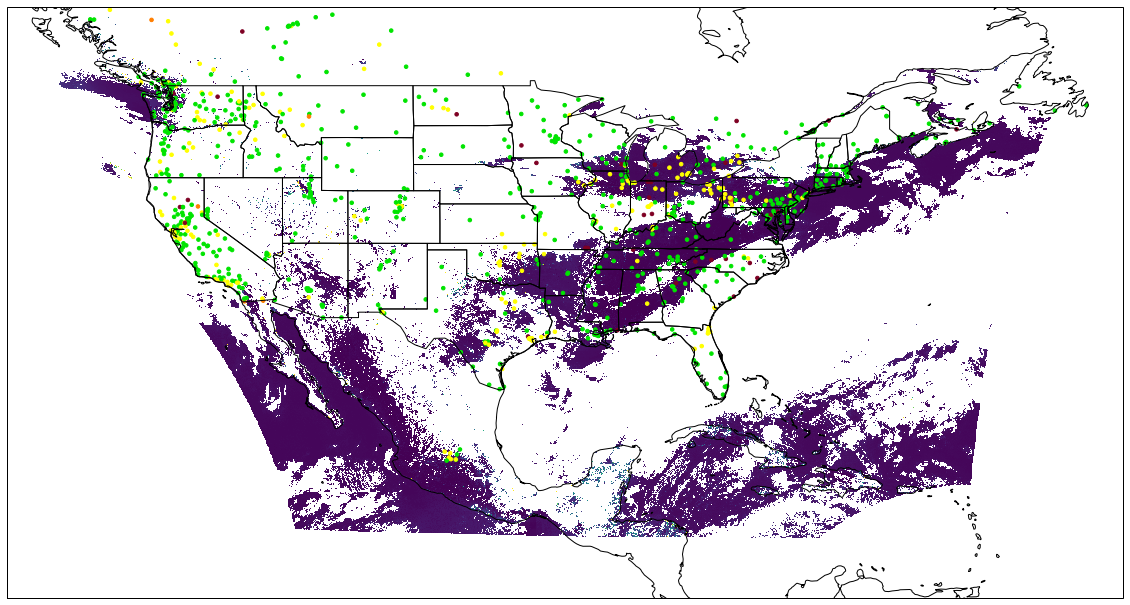

In [24]:
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# set the extent (x0, x1, y0, y1) of the map in the given 
ax.set_extent([-135, -50, 10, 55], crs=ccrs.PlateCarree())

ax.imshow(np.flipud(AOD), origin='lower', #cmap = "Blues",
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='none')

ax.coastlines(resolution="50m")
ax.add_feature(ccrs.cartopy.feature.STATES)

ax.scatter(df_monitors["longitude"], df_monitors["latitude"],
           s=50, color=monitor_colors, marker=".")

Success! We can see monitors scattered on top of AOD and colored by their AQI category, but its a bit challenging to see what is going on and actually compare AOD and AQI from the CONUS level. It seems like Pennsylvania has enough monitors and AOD values to make a good comparison between the two, so lets modify the extent to take a closer look at Pennsylvania.

By dropping some pins on Google Maps, I found the (approximate) latitutudes and longitudes of the corners of Pennsylvania.
* southwest corner: 39.6, -80.7
* northeast corner: 42.1, -74.2

Text(1.0, 1.0, '19 March 2019 15:12 UTC ')

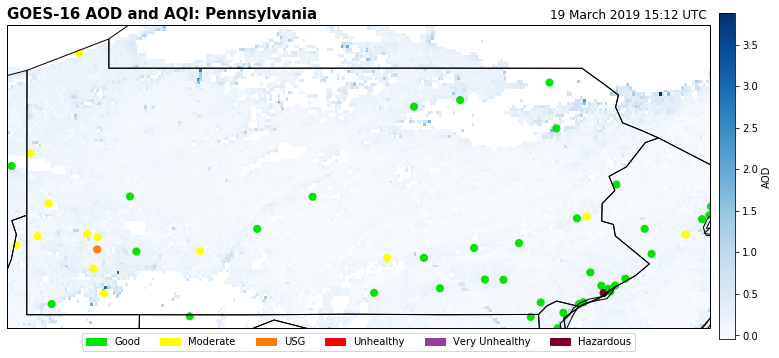

In [78]:
fig = plt.figure(figsize=(15, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# modify extent (x0, x1, y0, y1) to show us just Pennsylvania
ax.set_extent([-80.7, -74.2, 39.6, 42.4], crs=ccrs.PlateCarree())

im = ax.imshow(np.flipud(AOD), origin='lower', cmap = "Blues",
          extent=(x.min(), x.max(), y.min(), y.max()),
          transform=geos,
          interpolation='none')

ax.coastlines(resolution="50m")
ax.add_feature(ccrs.cartopy.feature.STATES)

ax.scatter(df_monitors["longitude"], df_monitors["latitude"],
           s=200, color=monitor_colors, marker=".")

# --- add a colorbar for AOD --- 

fig.colorbar(im, shrink=0.3, pad=0.01, label="AOD")

# --- add a legend for AQI ---

# Create "proxy artists" for use in legend. 
# See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
proxy_artists = []
for i in range(len(AQI_COLORS)):
    proxy_artists.append(mpatches.Patch(color=AQI_COLORS[i], label=AQI_NAMES[i]))

# Located legend with help from
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax.legend(handles=proxy_artists, loc="upper center",
          bbox_to_anchor=(0.5, 0), ncol=6)

plt.title('GOES-16 AOD and AQI: Pennsylvania', loc='left', fontweight='semibold', fontsize=15)
plt.title('%s' % scan_start.strftime('%d %B %Y %H:%M UTC '), loc='right')